<a href="https://colab.research.google.com/github/DJCordhose/llm-from-prototype-to-production/blob/main/Eval4pptx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on: LLM as a judge

Goal
* see how llm-as-a-judge works in principle
* introduction to the G-Eval algorithm ([G-Eval on arxive ](https://arxiv.org/abs/2303.16634))
* see how the algorithm uses prompts to generate the actual eval prompt
* try out the [DeepEval library](https://docs.confident-ai.com/docs/guides-using-custom-llms)


Requirements:
* OpenAI api key

# SetUp : create an *llm_run* method calling OpenAI Gpt

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time

!pip install openai
!pip install deepeval==1.1.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.9/365.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━

In [3]:
import os
from google.colab import userdata
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [4]:
def llm_run(messages):
  if type(messages) == str:
    messages = [{"role": "user", "content": messages}]

  client = OpenAI()
  completion = client.chat.completions.create(
    model="gpt-4o",
    messages=messages
  )
  return completion.choices[0].message.content

In [5]:
llm_run("who are you ?")

'I’m an artificial intelligence created by OpenAI, here to assist you with information, answer questions, and help with a variety of tasks. Is there something specific you need help with today?'

# LLM-as-a-judge: in principle

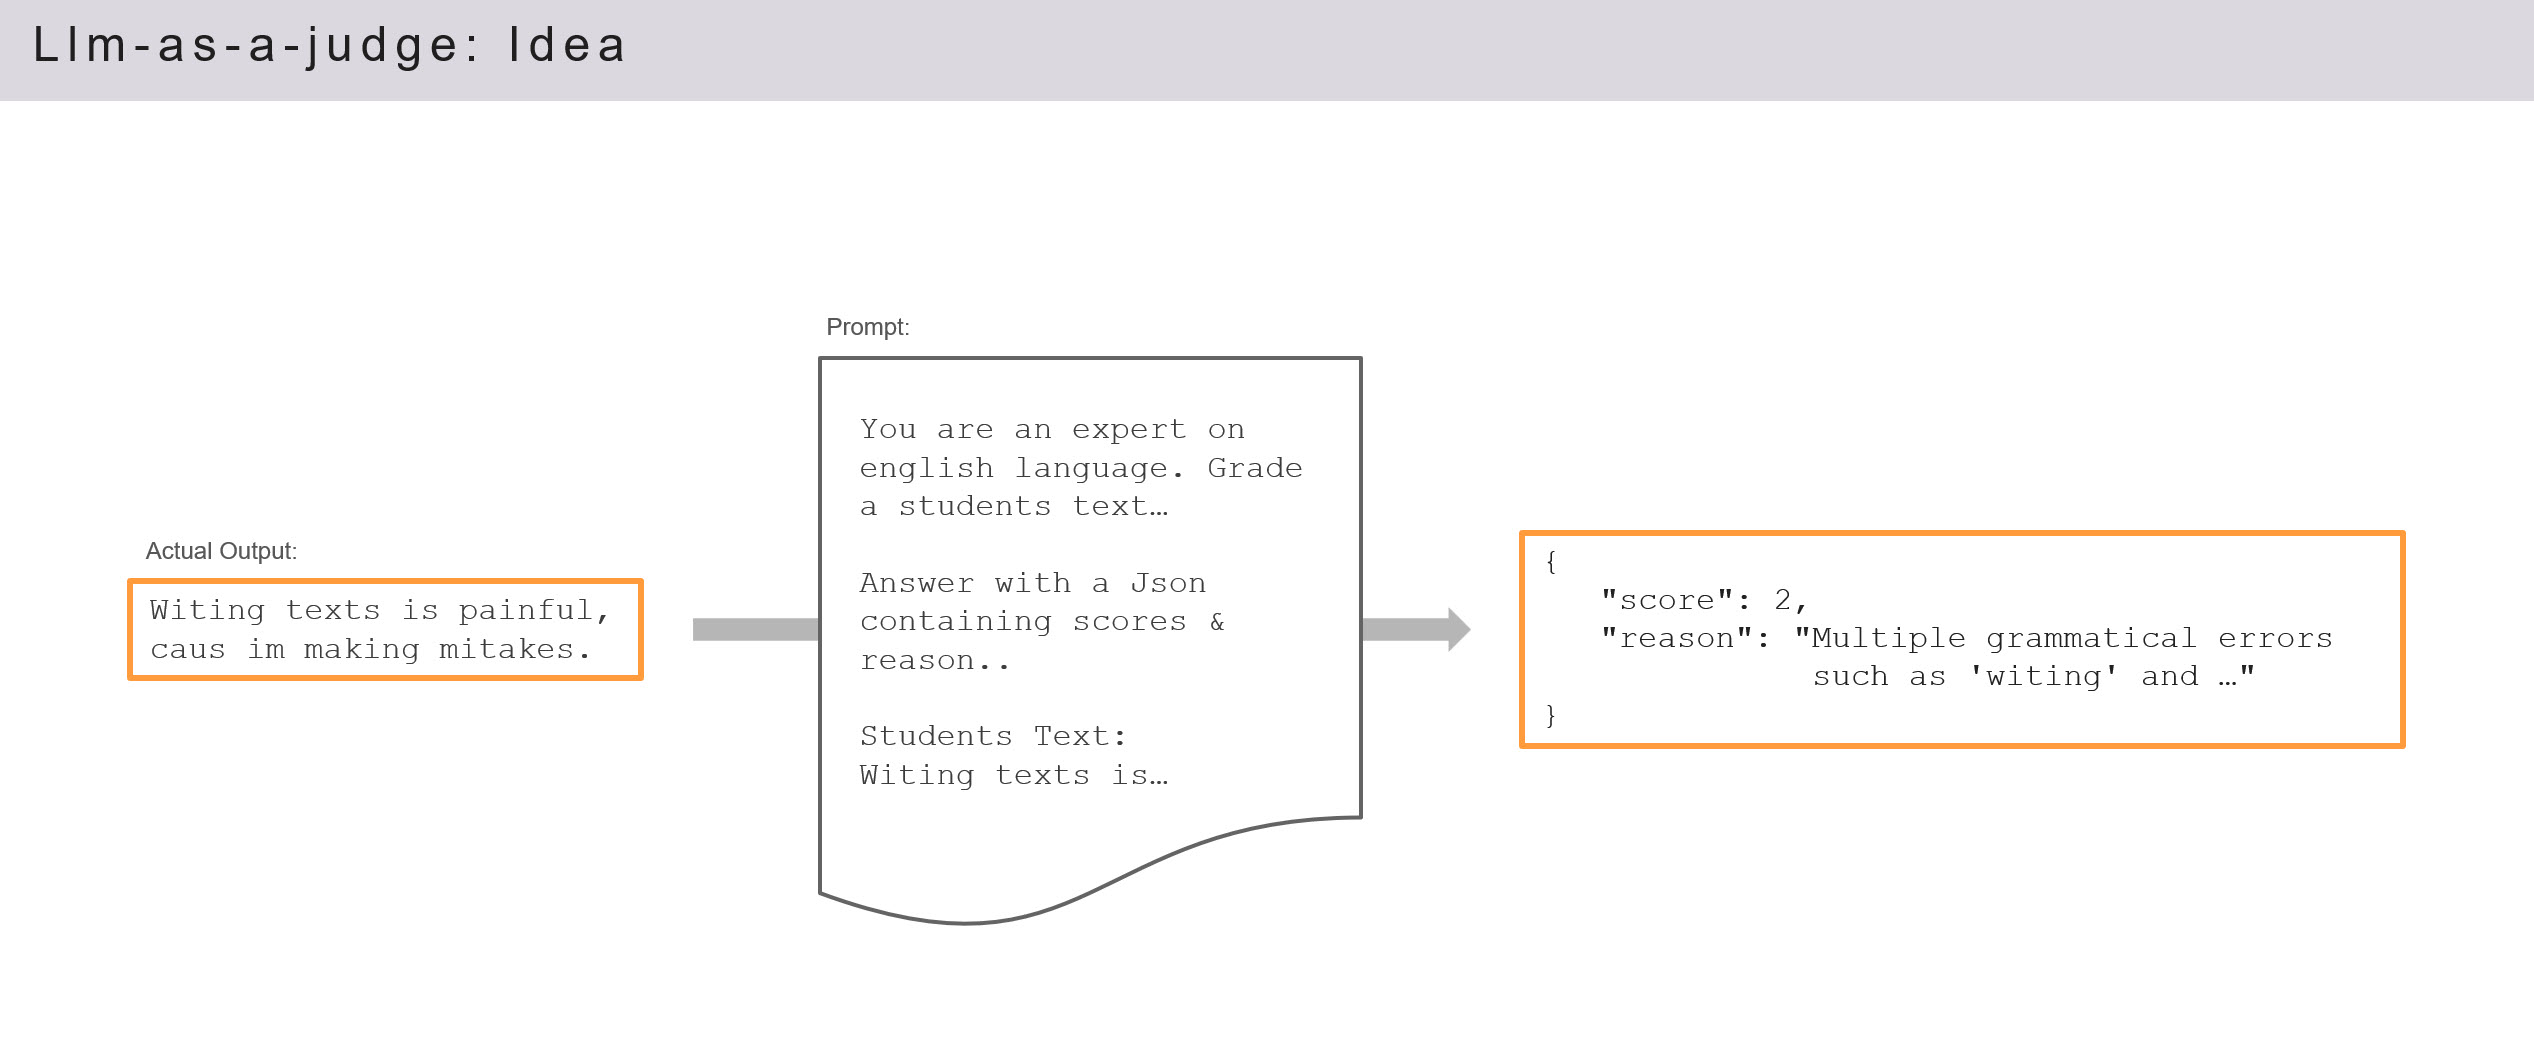





In [6]:
llm_output="Witing texts is painful, caus im making mitakes."

In [7]:
simple_eval_prompt = f'''
You are an expert on english language, grading a students text with scores between 0 and 10.
A text written in proper english, in a fluent style, containing no grammatical or syntax errors is graded 10.
A text written in a different language gets a lower score.
Also give a detailed explanation why the score was chosen.
Do not repeat the students text in your explanation.

Always answer in the following json format:
{{
    "score": 8,
    "reason": "some reason"
}}

Examples
1. Student Text: Pipes are cylindrical conduits used to transport fluids or gases, typically made of materials like metal, plastic, or concrete.
   Answer:
   {{
    "score": 8,
    "reason": "The text is written in english and does not contain any syntactical or grammatical erros"
  }}
2. Student Text: Zwischen Neonlichtern und Straßenlärm träum ich leise von Freiheit.
   Answer:
   {{
    "score": 2,
    "reason": "The text is written in german and not in english."
  }}

Student Text: {llm_output}
Answer:
'''

In [8]:
r=llm_run(simple_eval_prompt)
print(r)

{
    "score": 4,
    "reason": "The text is written in English but contains spelling and grammatical errors. For example, 'Witing' should be 'Writing,' 'caus' should be 'because,' and 'im making mitakes' should be 'I am making mistakes.'"
}


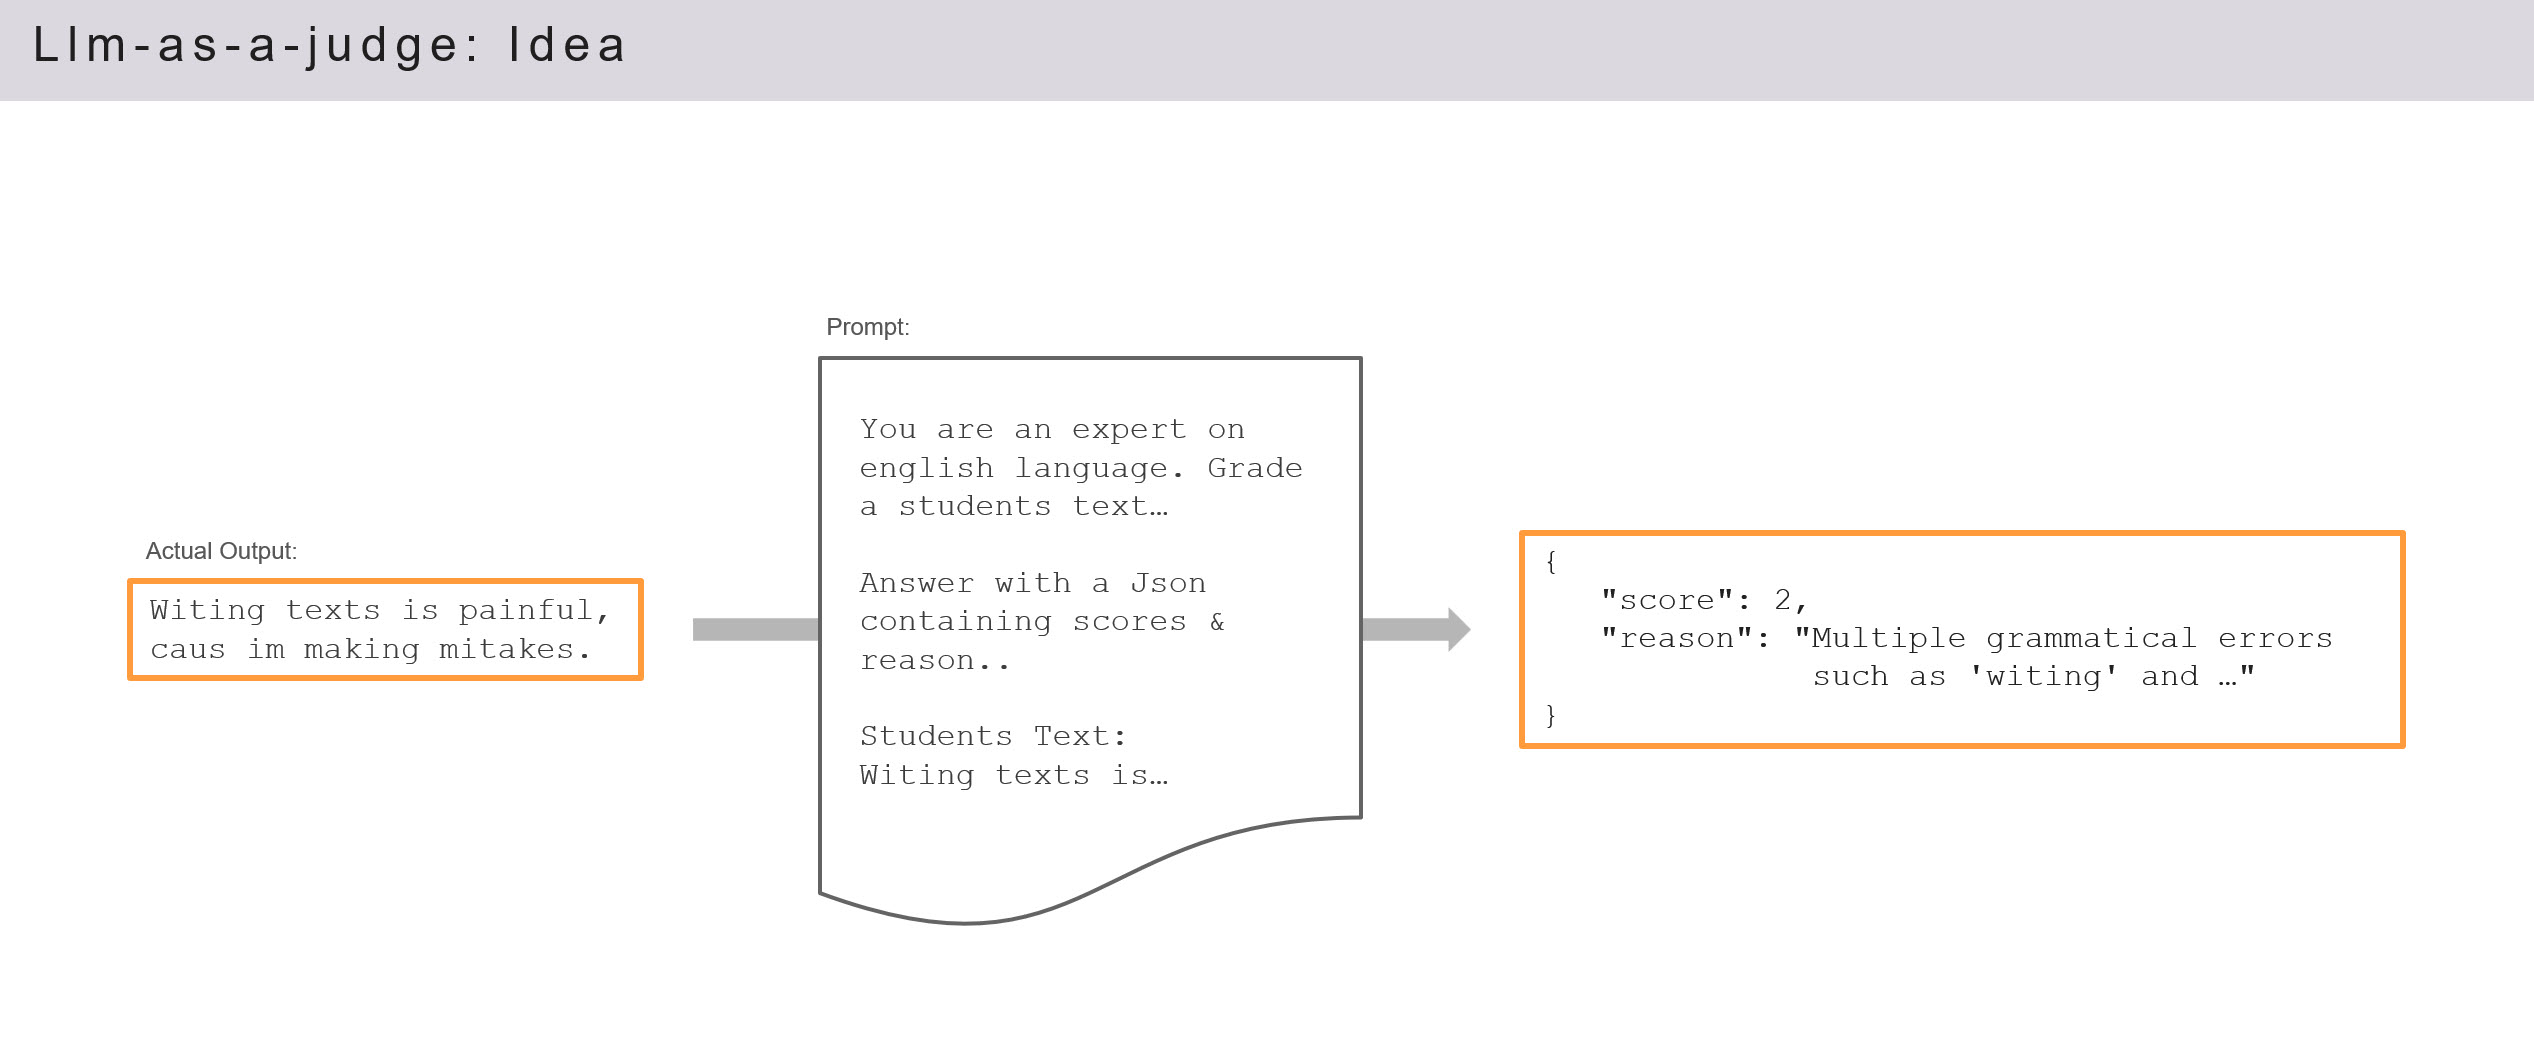





# Llm-as-a-judge: G-Eval in principal

https://arxiv.org/pdf/2303.16634












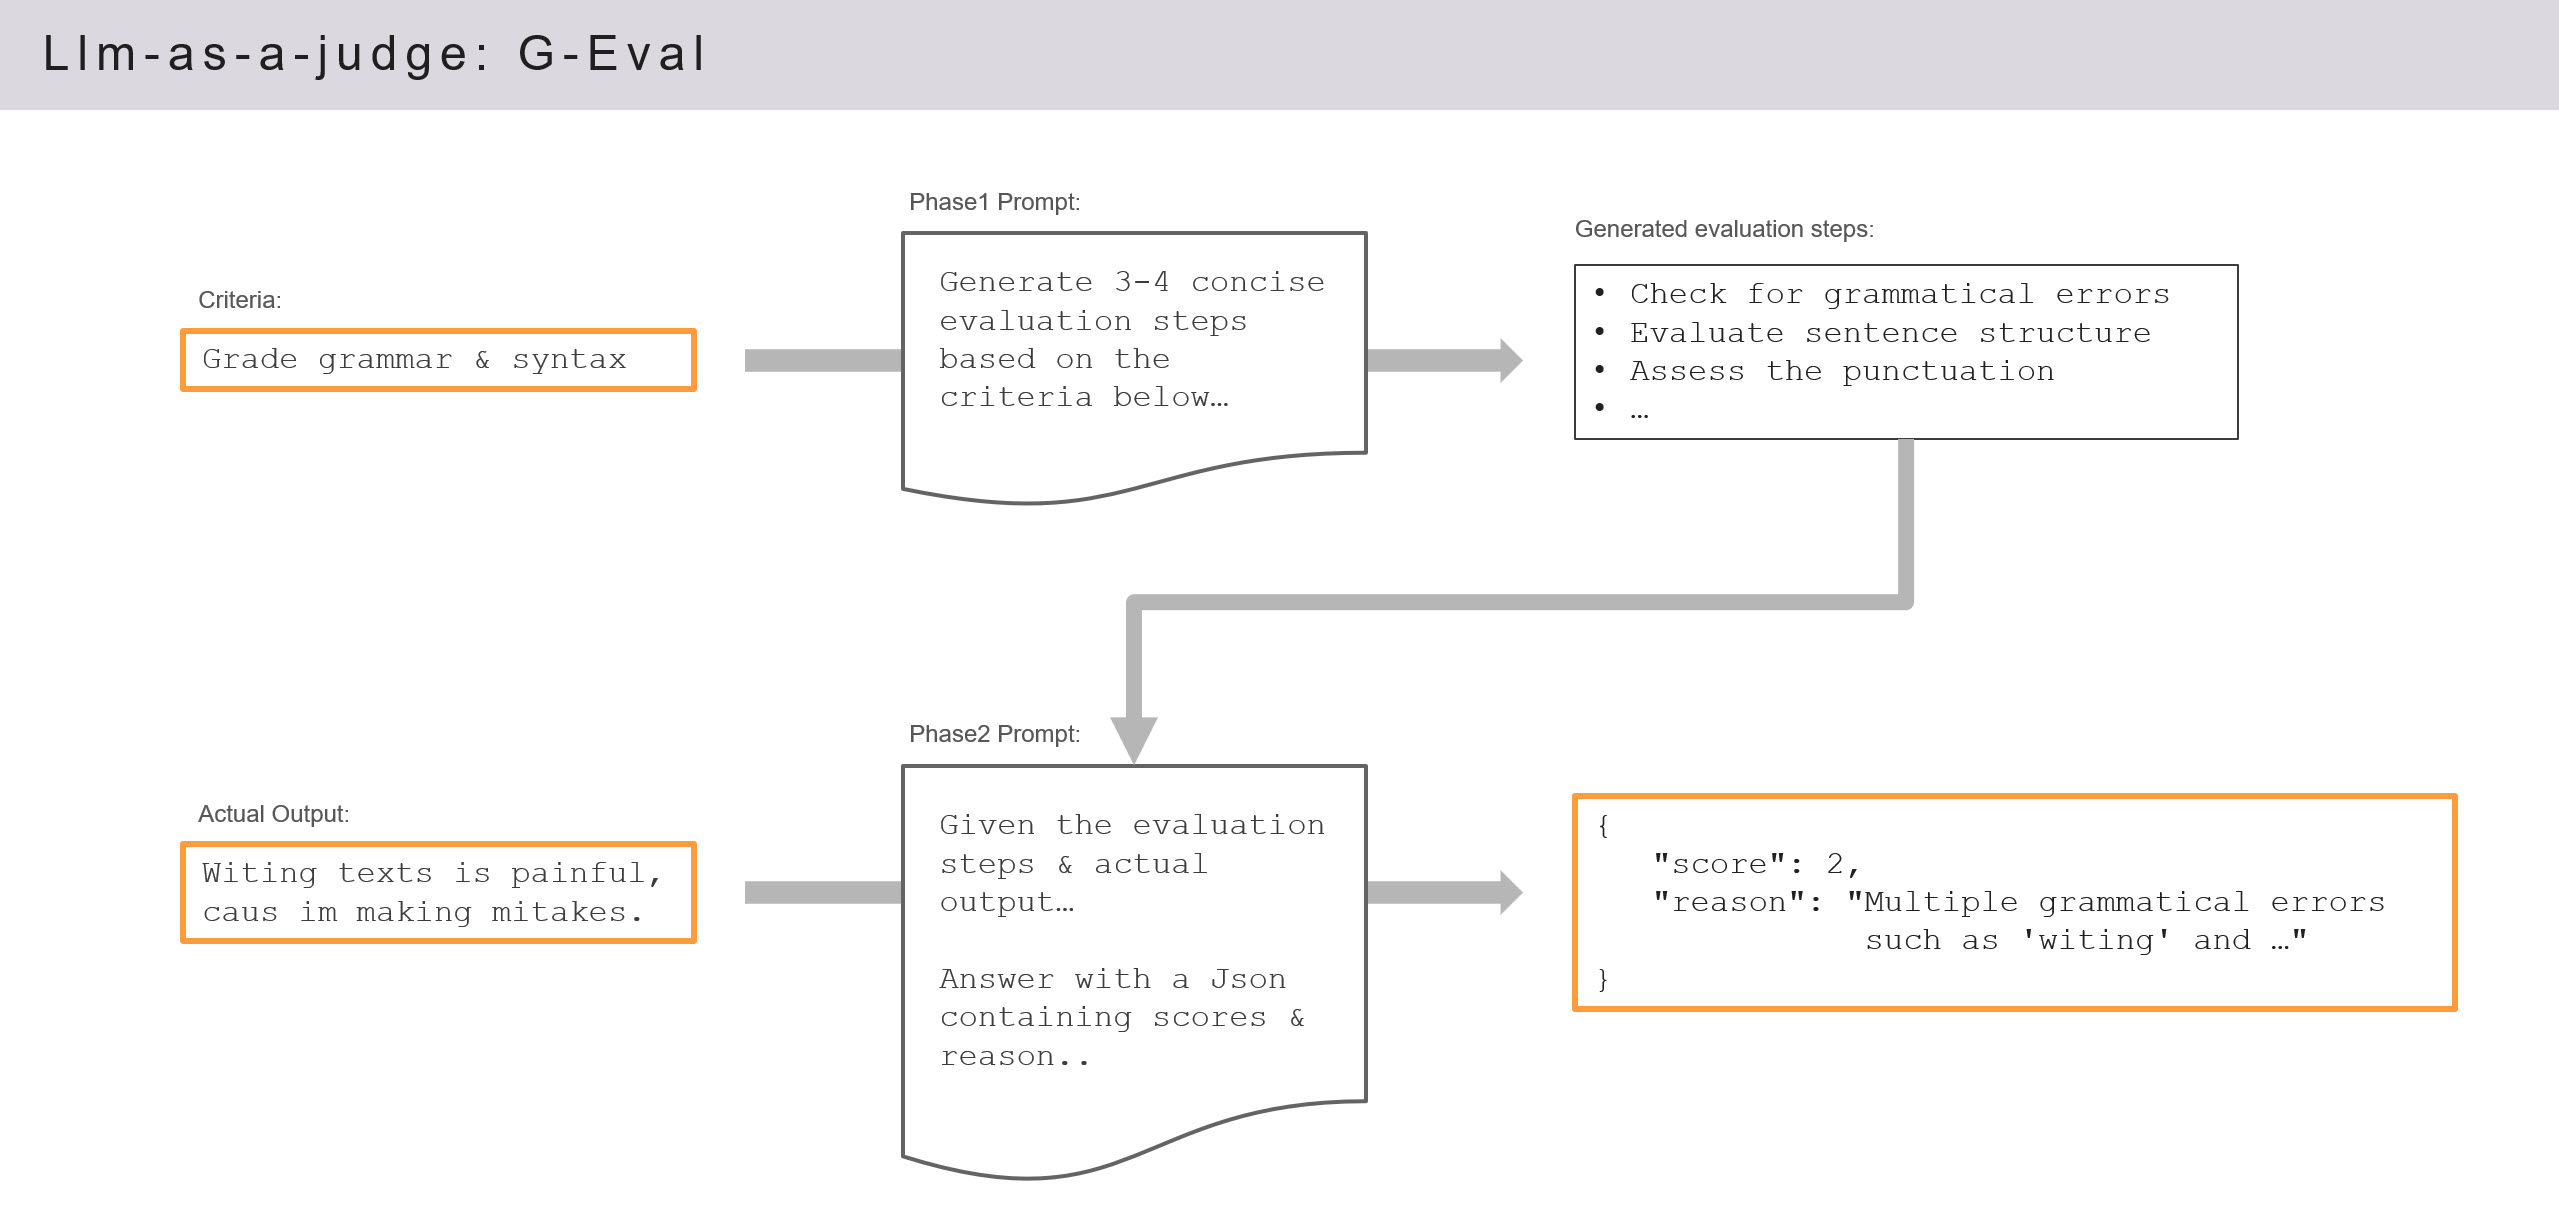

### G-Eval Phase 1: generate evaluation steps based on the criteria

In [9]:
criteria="Grade the english grammar and syntax"

In [10]:
geval_phase1_prompt = f'''Given an evaluation criteria which outlines how you should judge the Actual Output, generate
3-4 concise evaluation steps based on the criteria below. You MUST make it clear how to evaluate Actual Output in
relation to one another.

Evaluation Criteria:
{criteria}

**
IMPORTANT: Please make sure to only return in JSON format, with the "steps" key as a list of strings. No words or
explanation is needed. Do not prefix the output with "json".

Example JSON:
{{
    "steps": <list_of_strings>
}}
**

Answer:
'''
answer_phase1 = llm_run(geval_phase1_prompt)
print(answer_phase1)

{
    "steps": [
        "1. Check for proper use of punctuation, capitalization, and spelling.",
        "2. Evaluate the sentence structure for subject-verb agreement and proper use of tenses.",
        "3. Review the clarity and coherence of the sentences, ensuring they convey the intended meaning.",
        "4. Identify and assess the correct usage of phrases and idiomatic expressions."
    ]
}


In [11]:
import json

json_answer_step1=json.loads(answer_phase1)
steps="\n".join(f"{index+1}. {step}" for index, step in enumerate(json_answer_step1['steps']))
print(steps)

1. 1. Check for proper use of punctuation, capitalization, and spelling.
2. 2. Evaluate the sentence structure for subject-verb agreement and proper use of tenses.
3. 3. Review the clarity and coherence of the sentences, ensuring they convey the intended meaning.
4. 4. Identify and assess the correct usage of phrases and idiomatic expressions.


### G-Eval Phase 2: evaluate the llm_output using the generated steps

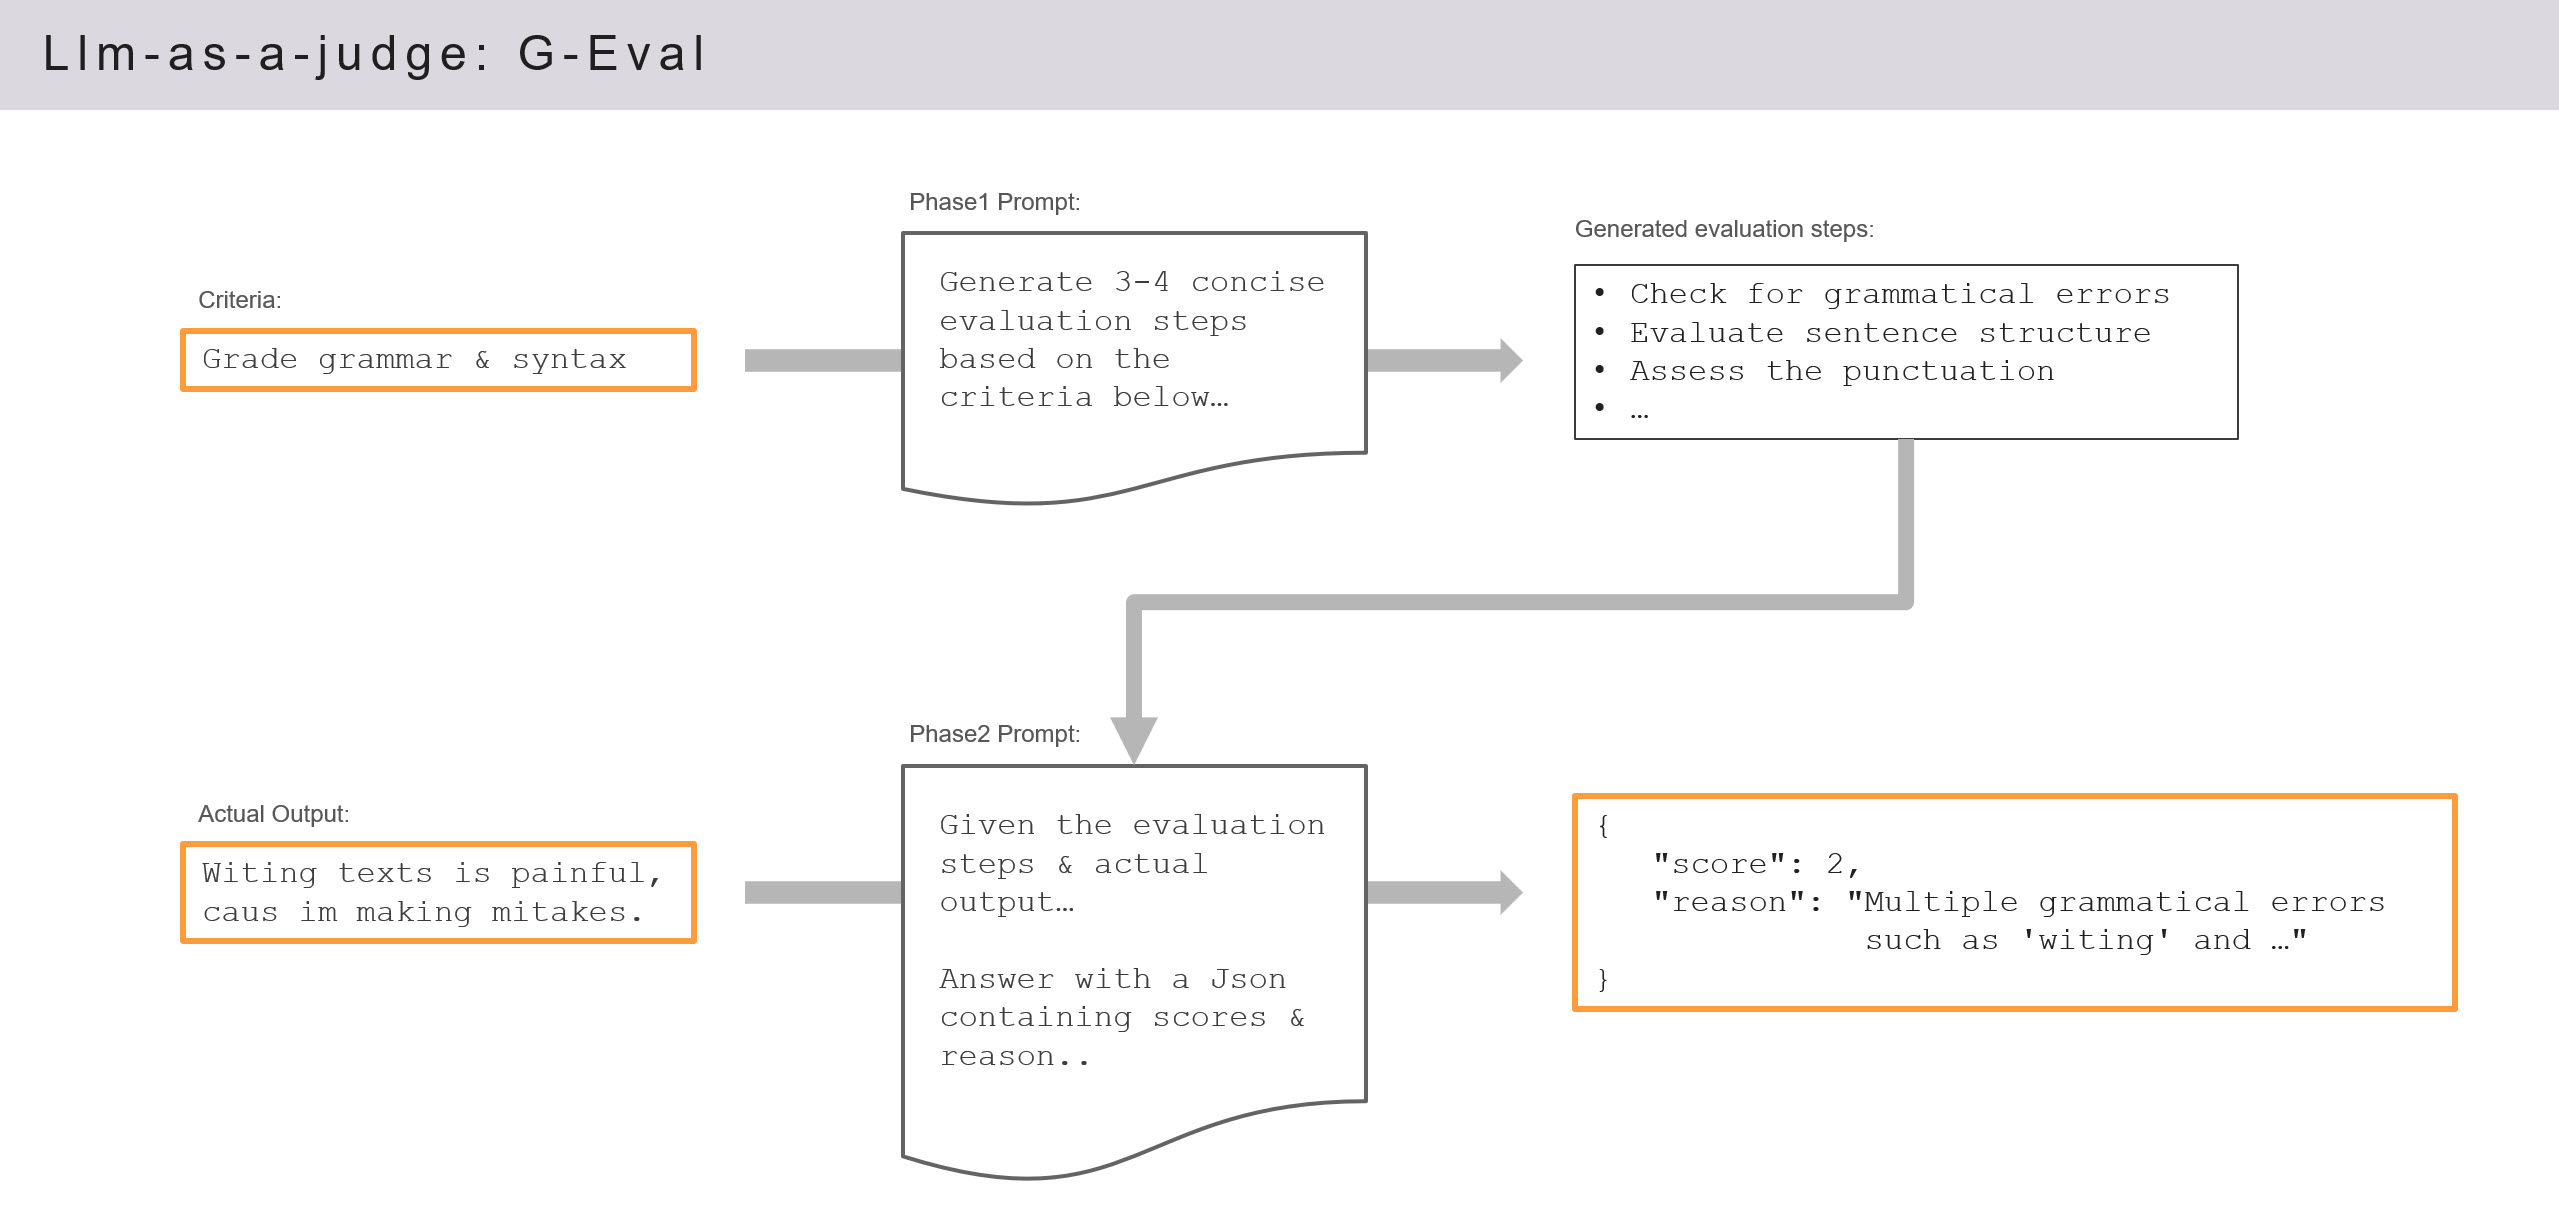

In [12]:
llm_input="Why do you dislike writing texts ?"
llm_output="Witing texts is painful, caus im making mitakes."

In [13]:
geval_phase2_prompt = f'''
Given the evaluation steps, return a JSON with two keys:
1) a `score` key ranging from 0 - 10, with 10 being that it follows the criteria outlined in the steps and 0 being that it does not, and
2) a `reason` key, a reason for the given score, but DO NOT QUOTE THE SCORE in your reason.
Please mention specific information from Actual Output and Input in your reason, but be very concise with it!

Evaluation Steps:
{steps}

Actual Output:
{llm_output}

Input:
{llm_input}

**
IMPORTANT: Please make sure to only return in JSON format, with the "score" and "reason" key. No words or explanation is needed.

Example JSON:
{{
    "score": 0,
    "reason": "The text does not follow the evaluation steps provided."
}}
**

Answer:
'''

In [14]:
answer_phase2=llm_run(geval_phase2_prompt)
print(answer_phase2)

{
    "score": 2,
    "reason": "The sentence contains several spelling errors ('Witing', 'caus', 'mitakes'), incorrect use of comma and capitalization, and lacks clarity and coherence in comparison to the input."
}


# G-Eval Implementation by DeepEval

In [15]:
import deepeval
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase

r=deepeval.evaluate(
   metrics=[ GEval( criteria="Grade the english grammar and syntax.",
                    name="Language",
                    model=None, # deepEval defaults to openAI
                    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT,LLMTestCaseParams.INPUT] ) ],
   test_cases=[ LLMTestCase( input=llm_input, actual_output=llm_output ) ]
)

Output()

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...




Metrics Summary

  - ❌ Language (GEval) (score: 0.20201287563898154, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The Actual Output contains spelling errors ('Witing', 'caus', 'mitakes') and improper grammar ('im making') compared to the Input., error: None)

For test case:

  - input: Why do you dislike writing texts ?
  - actual output: Witing texts is painful, caus im making mitakes.
  - expected output: None
  - context: None
  - retrieval context: None


Overall Metric Pass Rates

Language (GEval): 0.00% pass rate




🎉 Tests finished ✅! Run 'deepeval login' to view evaluation results on Confident AI. ‼️ NOTE: You can also run 
evaluations on ALL of deepeval's metrics directly on Confident AI instead.

# Evaluating multiple metrics: "Conciseness", AnswerRelevance, Toxicity,...

check out some other metrics [https://docs.confident-ai.com/docs/metrics-introduction](https://docs.confident-ai.com/docs/metrics-introduction)

In [16]:
from deepeval.metrics import AnswerRelevancyMetric, ToxicityMetric

def metrics_run(input, output):
    conciseness = GEval(
        name="Conciseness",
        criteria="Determine how concise the actual output is. Ignore the input.",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT],
    )
    language = GEval(
        name="Language",
        criteria="Grade the english grammar and syntax. Ignore the input.",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT],
    )
    metrics = [conciseness, language, AnswerRelevancyMetric(), ToxicityMetric() ]

    test_case = LLMTestCase(input=input, actual_output=output )
    return deepeval.evaluate( test_cases=[test_case], metrics=metrics )

In [20]:
r=metrics_run("Why do you dislike writing texts ?",
              "Witing texts is painful, caus im making mitakes.")

Output()

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...




Metrics Summary

  - ❌ Conciseness (GEval) (score: 0.4506025234021192, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The actual output is relatively short but contains spelling errors and redundant information ('Witing' instead of 'Writing', 'caus' instead of 'because', 'im' instead of 'I'm')., error: None)
  - ❌ Language (GEval) (score: 0.2373773788099459, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: Subject-verb agreement is correct, but there are major punctuation errors and sentence structure issues. Tense use is consistent., error: None)
  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response is perfectly relevant and directly addresses the question asked., error: None)
  - ✅ Toxicity (score: 0.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because the actual output contains no toxic elements and is completely appropria

🎉 Tests finished ✅! Run 'deepeval login' to view evaluation results on Confident AI. ‼️ NOTE: You can also run 
evaluations on ALL of deepeval's metrics directly on Confident AI instead.

In [21]:
r=metrics_run("What is a pipe used for ?",
              "A pipe is a tubular conduit used to transport fluids or sometimes solids.")

Output()

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...




Metrics Summary

  - ✅ Conciseness (GEval) (score: 0.8779400165681162, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The actual output is concise and addresses the input directly, but the mention of 'sometimes solids' is slightly unnecessary given the context., error: None)
  - ✅ Language (GEval) (score: 0.9914900947985832, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The text uses correct grammar, proper sentence structure, and clear syntax with no errors or awkward phrasing., error: None)
  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the answer is perfectly relevant and there are no irrelevant statements in the actual output. Great job!, error: None)
  - ✅ Toxicity (score: 0.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because the output is completely non-toxic and free from any harmful or offensive content., error: None)



🎉 Tests finished ✅! Run 'deepeval login' to view evaluation results on Confident AI. ‼️ NOTE: You can also run 
evaluations on ALL of deepeval's metrics directly on Confident AI instead.

In [22]:
r=metrics_run("What is a pipe used for ?",
              "Pipes are beautiful, black and round. Because they are round they are very convenient and don't have any edges.")

Output()

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...




Metrics Summary

  - ❌ Conciseness (GEval) (score: 0.25416524475160884, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The actual output is verbose and includes unnecessary adjectives and repetitive information., error: None)
  - ✅ Language (GEval) (score: 0.6030967439677368, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The output is mostly grammatically correct with proper sentence structure but does not directly answer the input question 'What is a pipe used for?'., error: None)
  - ❌ Answer Relevancy (score: 0.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because the output contains multiple irrelevant statements about the appearance and shape of the pipe, which do not address the input question about its use., error: None)
  - ✅ Toxicity (score: 0.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because the actual output contains no toxic elements and is completely a

🎉 Tests finished ✅! Run 'deepeval login' to view evaluation results on Confident AI. ‼️ NOTE: You can also run 
evaluations on ALL of deepeval's metrics directly on Confident AI instead.